# Creating custom datablocks for 3D images and fastai

In [39]:
import SimpleITK as sitk
import re
import pathlib

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [40]:
from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.data import *
from faimed3d.models import *


## Load data

In [41]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')

train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))

To reduce complexity of the data, only the T2 map will be used for the first runs. 

In [42]:
files = train_files + valid_files

In [43]:
# take only T2 images for now
subset_files =[]
for f in files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_files.append(Path(m.string))

In [44]:
segmentation_files = [(p.parent/'Annotation').ls()[0] for p in subset_files]

## Construct databunch

In [45]:
def GreatGreatGrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the great great grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _great_great_grandparent_idxs(o, train_name),_great_great_grandparent_idxs(o, valid_name)
    return _inner

In [46]:
def _great_great_grandparent_idxs(items, name):
    def _inner(items, name): return mask2idxs(Path(o).parent.parent.parent.parent.name == name for o in items)
    return [i for n in L(name) for i in _inner(items,n)]

In [47]:
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              MaskBlock3D(codes = ['void', "peripheral", 'transitional', 'cancer'])),
    get_x = lambda x: x[0],
    get_y = lambda x: x[1], 
    item_tfms = ResizeCrop3D(crop_by = (0.1, 0.15, 0.15), resize_to = (20, 150, 150), perc_crop = True),
    batch_tfms = [
        *aug_transforms_3d(p_all=0.25, do_rotate_by = False), 
        RandomCrop3D(((2, 2), (20,20), (25,25)), (0, 10, 10)), 
        ClampMask3D,
        PseudoColor],
    splitter = RandomSplitter())

In [48]:
d = pd.DataFrame({'isegmentation_files' : subset_files, 
                  'mask' : segmentation_files})

In [49]:
dls = mris.dataloaders(d, 
                       batch_size = 6, 
                       num_workers = 0,
                      )
dls.valid.bs = 6 # defaults to 64 and will cause Cuda out of Memory errors

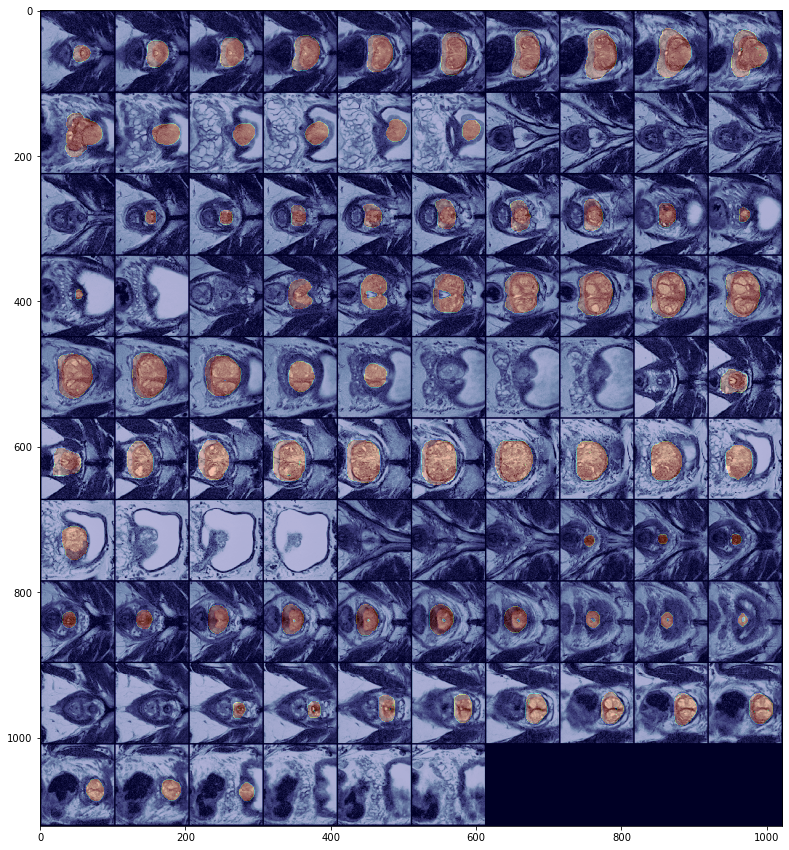

In [54]:
show_batch_3d(dls, with_mask =True)

## Train the model

In [45]:
def mcc_score_unet(preds, target):
    return 1-MCCLossBinary(smooth = 0.)(preds.round(), target)

In [46]:
mcc_loss = MCCLossBinary()

learn = Learner(dls, 
                UNet3D(n_channels = 1, n_classes = 2),
                opt_func = SGD, 
                loss_func = MCCLossMulti(2), 
      #          metrics = mcc_score_unet, 
                model_dir = '../models/',
                cbs = SaveModelCallback(fname = 'unet-whole-prostate')
               )
learn = learn.to_fp16()
learn.unfreeze()

In [47]:
learn = learn.load('../pretrained/unet-whole-prostate-20x100x100')

In [16]:
learn.fit_one_cycle(10, 0.1)

Better model found at epoch 0 with valid_loss value: 0.3098900020122528.
Better model found at epoch 4 with valid_loss value: 0.30419328808784485.
Better model found at epoch 5 with valid_loss value: 0.30234554409980774.
Better model found at epoch 7 with valid_loss value: 0.28331127762794495.
Better model found at epoch 8 with valid_loss value: 0.2800810635089874.


In [17]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-2')

Path('../models/unet-whole-prostate-2.pth')

In [18]:
learn.fit_one_cycle(10, 0.01)

Better model found at epoch 0 with valid_loss value: 0.28436794877052307.
Better model found at epoch 1 with valid_loss value: 0.27119266986846924.


In [19]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-3')

Path('../models/unet-whole-prostate-3.pth')

In [20]:
learn.fit_one_cycle(10, 0.001)

Better model found at epoch 0 with valid_loss value: 0.2793900966644287.
Better model found at epoch 1 with valid_loss value: 0.2757475674152374.
Better model found at epoch 6 with valid_loss value: 0.27340272068977356.


In [21]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-4')

Path('../models/unet-whole-prostate-4.pth')

In [37]:
learn.fit_one_cycle(10, 0.0001)

Better model found at epoch 0 with valid_loss value: 0.3078034222126007.


In [23]:
learn = learn.load('unet-whole-prostate')
learn.save('unet-whole-prostate-5')

Path('../models/unet-whole-prostate-5.pth')

In [48]:
x_in, y_pred, y_orig = learn.get_preds(with_input = True)

In [49]:
x_in = TensorDicom3D(x_in)
y_pred = TensorDicom3D(y_pred[:,0,:,:,:])
y_orig = TensorDicom3D(torch.clamp(y_orig, 0, 1))

/home/bressekk/Documents/faimed3d/nbs/faimed3d/basics.py:75: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Assuming the 1st dimension is a (fake) color channel it will be removed
  warn(w)


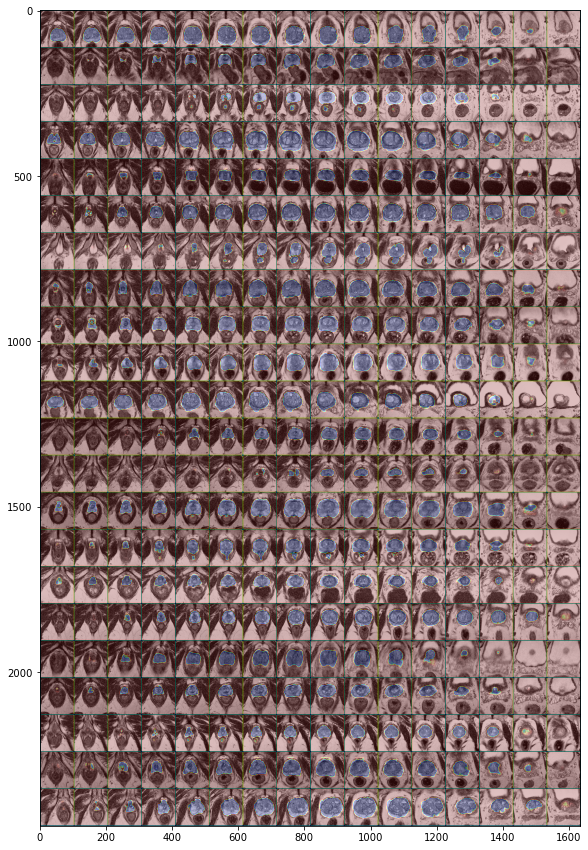

In [50]:
x_in.show(cmap = 'gray', nrow = 16)
y_pred.show(add_to_existing = True, alpha = 0.25, cmap = "jet", nrow = 16)

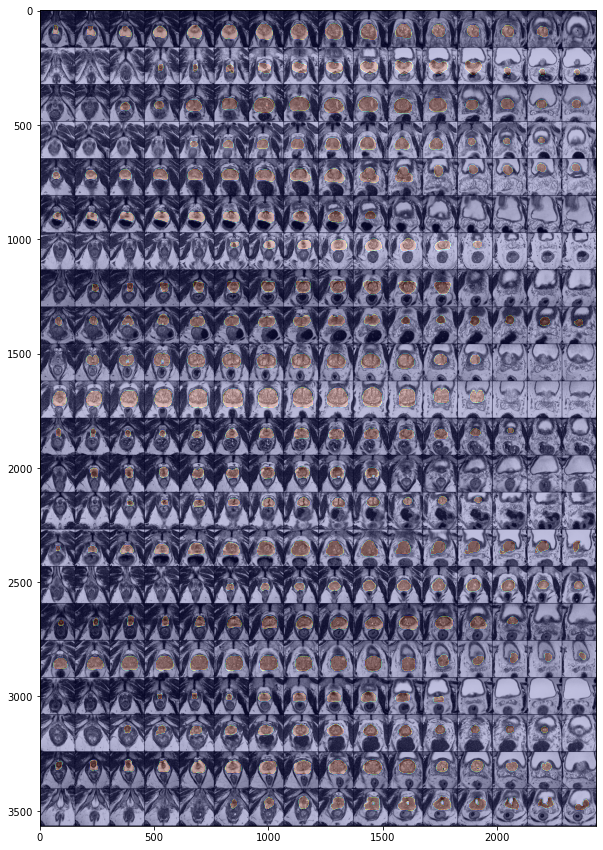

In [27]:
x_in.show(cmap = 'gray', nrow = 16)
y_orig.show(add_to_existing = True, alpha = 0.25, cmap = "jet", nrow = 16)